#### **Universidade Federal da Bahia.**
#### **Departamento de Eng. Elétrica e Computação**
#### **Avaliação 3 - Introdução ao Aprendizado de Máquina**
#### Semestre: 2023.2
#### Alunos : Ricardo Machado e Rodrigo Pimentel

### Resumo:

### Questão 1: Escolha uma tarefa de classificação ou regressão que possa ser abordada utilizando Perceptrons Multicamadas (MLPs). Selecione um conjunto de dados apropriado (sugestões em https://archive.ics.uci.edu/). Projete e treine uma rede MLP de duas camadas para resolver a tarefa desejada. Utilize o método de validação cruzada k-fold para avaliar o treinamento do modelo.

In [16]:
#Importação de bibliotecas utilizadas no trabalho.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, mean_squared_error

plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = [8, 6]

#### Carregamento do banco de dados.

O banco de dados utilizado contém 3810 instâncias de imagens de grãos de arroz de duas espécies diferentes: Cammeo e Osmancik.

Os atributos preditivos do conjunto de dados são: Área, Perímetro, Comprimento do Eixo Maior, Comprimento do Eixo Menor, Excentricidade, Área Convexa e Extensão.

In [2]:
!pip3 install -U ucimlrepo

In [3]:
#Banco de dados utilizado. https://archive.ics.uci.edu/dataset/545/rice+cammeo+and+osmancik
from ucimlrepo import fetch_ucirepo
rice_cammeo_and_osmancik = fetch_ucirepo(id=545)
X = rice_cammeo_and_osmancik.data.features
y = rice_cammeo_and_osmancik.data.targets
df = pd.concat([X, y], axis=1)


#### Análise e pré-processamento de dados.

In [4]:
df.describe()

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent
count,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000
mean,12667.727559,454.239180,188.776222,86.313750,0.886871,12952.496850,0.661934
std,1732.367706,35.597081,17.448679,5.729817,0.020818,1776.972042,0.077239
min,7551.000000,359.100006,145.264465,59.532406,0.777233,7723.000000,0.497413
25%,11370.500000,426.144752,174.353855,82.731695,0.872402,11626.250000,0.598862
50%,12421.500000,448.852493,185.810059,86.434647,0.889050,12706.500000,0.645361
75%,13950.000000,483.683746,203.550438,90.143677,0.902588,14284.000000,0.726562
max,18913.000000,548.445984,239.010498,107.542450,0.948007,19099.000000,0.861050


A primeira análise consiste em gerar a descrição estatística para o banco de dados. Pela média e mediana de cada um dos atributos é perceptível a diferença de escala entre eles.

<Axes: >

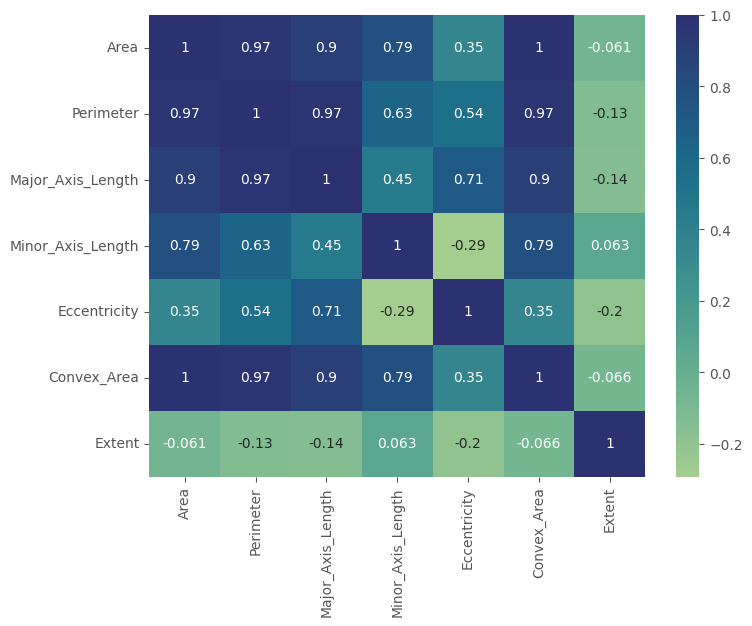

In [5]:
matriz_corr = X.corr(numeric_only=True)
sns.heatmap(matriz_corr,annot=True,cmap="crest")

Para visualizar como os atributos do banco de dados estão relacionados decide-se plotar o mapa de calor da matriz de correlação.

##### Geração do boxplot para todos os atributos.

<Axes: xlabel='Class', ylabel='Area'>

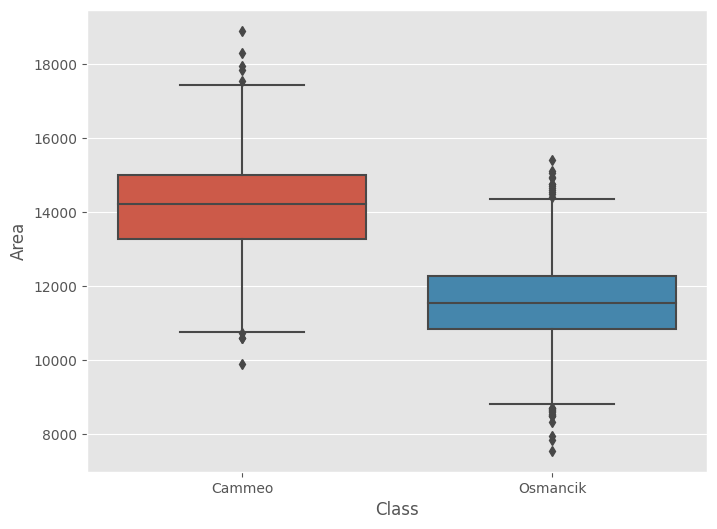

In [6]:
sns.boxplot(data=df, y=df.Area,x=df.Class)

Continuar texto boxplot

Devido à diferença de escala entre os atributos utiliza-se a normalização min-max no conjunto de dados.

In [7]:
scaler = MinMaxScaler(feature_range = (0,1))
X_norm = scaler.fit_transform(X,y)

Em relação ao atributo alvo, é necessário aplicar uma conversão simbólico-numérico nos dados para trabalhar com o classificador MLP.

In [8]:
label_encoder = LabelEncoder()
y_numerico = label_encoder.fit_transform(y)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Separação do banco de dados nos conjuntos de teste e treinamento.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y_numerico,test_size= 0.3,random_state=2)

Distribuição dos dados:

In [13]:
print("Quantidade de dados de treino: ", len(X_train))
print("Quantidade de dados de teste: ", len(X_test))

print("Quantidade de dados de treino e atributos: ", X_train.shape)
print("Quantidade de dados de teste e atributos: ", X_test.shape)

print("Quantidade de saídas de treino e colunas: ", y_train.shape)
print("Quantidade de saídas de teste e colunas: ", y_test.shape)


Quantidade de dados de treino:  2667
Quantidade de dados de teste:  1143
Quantidade de dados de treino e atributos:  (2667, 7)
Quantidade de dados de teste e atributos:  (1143, 7)
Quantidade de saídas de treino e colunas:  (2667,)
Quantidade de saídas de teste e colunas:  (1143,)


#### Inicialização do modelo MLP.

In [14]:
mlp_clf = MLPClassifier(random_state=2, max_iter=300).fit(X_train, y_train)

O modelo utilizado consiste num classificador Multilayer Perceptron(MLP) de duas camadas: uma oculta e uma de saída.
A função GridSearchCV do scikit-learn é utilizada para escolher o número de neurônios na camada oculta que resulta na melhor acucária entre as seguintes opções:

Camada oculta com 50, 60, 75, 90 ou 100 neurônios.


In [22]:
param_grid = {
    'hidden_layer_sizes': [(50,),(60,),(75,),(90,),(100,)]
}

grid_search = GridSearchCV(mlp_clf, param_grid, cv=10, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Número de neurônios que resulta na maior acucária:", grid_search.best_params_)
print("Acucária máxima:",grid_search.best_score_ )

Número de neurônios que resulta na maior acucária: {'hidden_layer_sizes': (60,)}
Acucária máxima 0.9309960293993409


In [21]:
print(grid_search.cv_results_['mean_test_score'])

[0.93062009 0.93099603 0.92799273 0.92611726 0.93099603]


A acurácia máxima alcançada foi com uma camada oculta de 60 neurônios. Portanto, o MLP empregado adotará esse valor como hiperparâmetro.

In [23]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(60,),random_state=2, max_iter=300).fit(X_train, y_train)

In [24]:
mlp_clf.fit(X_train,y_train)

MLPClassifier(hidden_layer_sizes=(60,), max_iter=300, random_state=2)

#### Avaliação da perfomance do modelo.

A primeira avaliação do modelo realizada é a validação cruzada k-fold com a divisão em 10 subconjuntos.

In [29]:
score_val_cruzada_mlp = cross_val_score(mlp_clf, X_train, y_train, cv=10)

In [30]:
np.mean(score_val_cruzada_mlp)

0.9309960293993409

A acurácia média obtida para o modelo com a validação cruzada 10-fold é de 93%.

Para realizar comparações de perfomance, utiliza-se o Classificador Dummy no conjunto de dados, a fim de estabelecer uma referência inicial para o desempenho.

In [31]:
dummy_clf = DummyClassifier(random_state=2)

In [32]:
dummy_clf.fit(X_train,y_train)

DummyClassifier(random_state=2)

In [35]:
score_val_cruzada_dummy = cross_val_score(dummy_clf, X_train, y_train, cv=10)

In [36]:
np.mean(score_val_cruzada_dummy)

0.5665554335276394

A acurácia média obtida para o modelo dummy com a validação cruzada 10-fold é de 56,66%. Portanto, o modelo Multilayer perceptron utilizado no trabalho é sigficativamente melhor que o classificador dummy.